# **CMPUT 466/566 - CNN [ 25 marks]**


### **RESOURCES**
This assignment requires some basic knowledge of Pytorch which can be found in the following links:


1.   [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
2.   [Build the Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
3. [Optimizing Model Parameters](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)
4. [torch.nn](https://pytorch.org/docs/stable/nn.html)
5. [ResNet](https://pytorch.org/hub/pytorch_vision_resnet/)




### **DATASET**
The dataset is from [Kaggle](https://www.kaggle.com/datasets/die9origephit/children-vs-adults-images) and has been modified for some questions. The shared ***'balanced_data'*** folder contains the balanced dataset and ***'imbalanced_data'*** contains its modified version for Part IV with class imbalance. 

The dataset can be found [here](https://drive.google.com/drive/folders/1WMYnKezCICtLNwnp9-eeK0220X6Hjlfm?usp=sharing) 

Load the data on Google colab from Google drive:
1. Click on the Google Drive link of the **datasets** folder (make sure you login with your ualberta.ca email address)
2. Click on the drop down next to the name of the folder and select **Add Shortcut to Drive**

<center><img src='https://drive.google.com/uc?id=155oG91lcrqIxLQ1K3XJUzBLhrcOMmkqn' width="300" 
     height="400" ></center>

4. Come back to the **copy of this colab notebook** and mount the drive by running the cell below


In [ ]:
from google.colab import drive
#make sure you give the necessary authorization for colab to access your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


5. Click Connect to **Google Drive**


<center><img src='https://drive.google.com/uc?id=1vVU4anE7Wo_BRBDrW_dZ8_ck-BbMmbLR' width="800" 
     height="150" ></center>


6. **Choose your ualberta.ca account**

<center><img src='https://drive.google.com/uc?id=1GkRAHOxpgAe4_Dsb0MY1ZdcR5RfyWxne' width="300" 
     height="400" align='middle' ></center>

7. **Grant permission**


<center><img src='https://drive.google.com/uc?id=17qYsveplhjnynP-tmPQnhZSEmv_x3oa7' width="400" 
     height="700" align='middle' ></center>


8. If you want to access a folder called **'datasets'**, you can do this with:



```
dataset_dir = '/content/drive/MyDrive/datasets'
```





In [ ]:
'''
Follow the above steps and include the paths for training and test datasets
'''
main_path = '/content/drive/MyDrive/datasets/imbalanced_data/train' #ENTER PATH HERE
test_path = '/content/drive/MyDrive/datasets/imbalanced_data/test' #ENTER PATH HERE

### **Part I:  Activation functions for CNN [ 6 marks ]**

In [ ]:
#Loading necessary libraries
import numpy as np
import pandas as pd 
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler, Adam, SGD
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import os
import glob
import time
from sklearn.metrics import balanced_accuracy_score
from torch.autograd import Variable
from torch.nn import Linear, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm
from torchvision import models
'''
Import any necessary libraries here to keep your code organized
'''
#import <some_library> 
from math import sin

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
my_transforms = transforms.Compose([transforms.Resize((224,224)),   transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
BATCH_SIZE = 16
IMAGE_SIZE = 32
NUM_CHANNELS = 3
n_epochs = 50 # the cnn will be trained for 50 epochs
dataset = datasets.ImageFolder(root=main_path, transform=my_transforms)
dataset_size = dataset.__len__() #compute the length of the training dataset
train_count = int(dataset_size * 0.8) #divide the training dataset to training and validation splits
val_count = dataset_size - train_count # keep the training proportion to 1 if no validation is required
train_dataset, valid_dataset = data.random_split(dataset, [train_count, val_count]) #perform a random split on the dataset based on the train and validation proportion
y_train_indices = train_dataset.indices
y_train = [dataset.targets[i] for i in y_train_indices] #assign the labels or target variables to y_train (classes)
test_data = datasets.ImageFolder(test_path, transform=my_transforms)
'''
Following train, validation and test dataloaders will also be used in Part III: Resnets
'''
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=BATCH_SIZE)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #check for gpu

print('Using ',device,'for model training') #print the device status

Using  cpu for model training


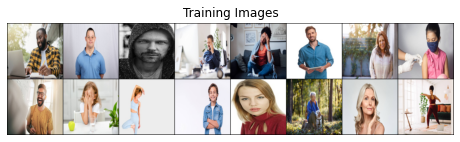

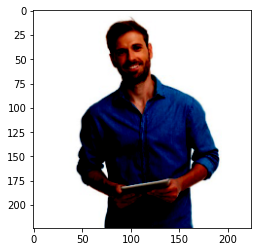

Label: 0


In [ ]:
#Visualize some training images
'''
DO NOT ALTER THE FOLLOWING CODE
'''
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
plt.imshow(real_batch[0][5].permute(1,2,0), vmin=0, vmax=255)
plt.show()

print(f"Label: {real_batch[1][5]}")

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def make_train_step(model, optimizer, loss_fn):
  '''
  INPUT: model, optimizer, loss function
  OUTPUT: train step
  '''
  def train_step(x,y):
    '''
    This function is used to train the model and update the model parameters. Do not change this function
    '''
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss

  return train_step

In [ ]:
'''
DO NOT ALTER THE FOLLOWING CODE
'''
def train_model(model,n_epochs, loss_fn, train_step):
  '''
  This is the main function which is used to train the model, update weights, calculate loss and save the best model
  '''
  train_losses = []
  val_losses = []
  epoch_train_losses = []
  epoch_val_losses = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(train_dataloader), total = len(train_dataloader)): #iterate ove batches
      x_batch , y_batch = data
      x_batch = x_batch.to('cuda') #move to gpu
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to('cuda') #move to gpu
      loss = train_step(x_batch, y_batch)
      epoch_loss += loss/len(train_dataloader) 
      train_losses.append(loss.cpu().detach().numpy())
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))
    #validation does not require gradient
    with torch.no_grad():
      cum_loss = 0
      for x_batch, y_batch in valid_dataloader:
        x_batch = x_batch.to('cuda')
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to('cuda')
        model.eval()#model to eval mode
        yhat = model(x_batch)
        val_loss = loss_fn(yhat,y_batch)
        cum_loss += loss/len(valid_dataloader)
        val_losses.append(val_loss.item())
      epoch_val_losses.append(cum_loss)
      print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))   
      best_loss = min(epoch_val_losses)  
      #save best model
      if cum_loss <= best_loss:
        best_model_wts = model.state_dict()  
  #load best model
  model.load_state_dict(best_model_wts)
  return model, train_losses,val_losses

def plot_losses(train_losses,val_losses):
  '''
  This function can be used to plot the training and validation losses. You can use this 
  function to analyse the losses and judge if model was overfitting or if model shows some 
  unusual behaviour. 
  '''
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.show()

def inference(model,test_data):
  '''
  As we are doing binary classification, this function uses sigmoid to change class probabilities 
  to either 0 or 1 class. 
  '''
  y_pred = []
  y_true = []
  for idx in range(1, len(test_data)):
    y_true.append( test_data[idx][1])
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to('cuda')
    if torch.sigmoid(model(sample)) < 0.5:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred, y_true

def calc_loss(model, n_epochs):
  '''
  This function drives the training function, assigns the loss fuction and sets the optimiizer.
  '''
  loss_fn = BCEWithLogitsLoss() 
  optimizer = torch.optim.Adam(model.parameters()) 
  train_step = make_train_step(model, optimizer, loss_fn)
  trained_model, train_losses, val_losses = train_model(model,n_epochs, loss_fn, train_step)
  return trained_model

def calc_accuracy(trained_model):
  '''
  This function is used for returning the calculated accuracies.
  '''
  y_pred, y_true = inference(trained_model,test_data)
  target_names = ['Adults', 'Kids']
  print('the accuracy is',accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred, target_names=target_names))
  print('the balanced accuracy is',balanced_accuracy_score(y_true, y_pred))
  return accuracy_score(y_true, y_pred)

#### **Consider the following code snippet for a Neural Network**

This Network is a very simple Network for your reference to implement a Neural Network of any given architecture. 


```
class Net(Module):   
    
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(100352, 1)
        )
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

trained_model = calc_loss(model, n_epochs)
calc_accuracy(trained_model)
```



#### **(1) Build a CNN for the following Model Architecture [3 marks]**


```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)
```

The codebase is as follows:


In [ ]:
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here:
        '''
        #ENTER CODE HERE
        self.flatten = nn.Flatten()
        self.cnn = nn.Sequential(
          Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

          Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

          Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.fully = nn.Sequential(
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=50176, out_features=4096, bias=True),

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=4096, bias=True),

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=1000, bias=True),
 
          nn.Linear(in_features=1000, out_features=1, bias=True)
        )


    def forward(self, x):
        '''
        Define the forward pass
        '''
        #ENTER CODE HERE
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fully(x)
        return x
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm

  0%|          | 0/22 [00:00<?, ?it/s]


RuntimeError: ignored

#### **(2) Activation Functions [3 marks]**
Plug in the following Activation Functions:

1. ReLU
2. SiLU
3. Sigmoid
4. Tanh
5. ELU


Your Network Architecture should be as follows:



```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
    (2): YOUR ACTIVATION FUNCTION COMES HERE
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)
```








In [ ]:
'''
Build the Network Architecture: (keep in mind the activation functions)
Try it out for ReLU, SiLU, Sigmoid, Tanh, ELU individually
'''
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
  
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here:
        '''
        #ENTER CODE HERE

        self.cnn = nn.Sequential(
          Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
          
          Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
          
          Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          
          Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          
          Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          
          Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          )

        self.fully = nn.Sequential(
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=50176, out_features=4096, bias=True),
          nn.ReLU(),

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=4096, bias=True),
          nn.ReLU(),

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=1000, bias=True),
          nn.ReLU(),
 
          nn.Linear(in_features=1000, out_features=1, bias=True)
          
        )

    def forward(self, x):
        '''
        Define the forward pass
        '''
        #ENTER CODE HERE
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fully(x)
        return x
'''
DO NOT ALTER THE FOLLOWING CODE
'''
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

100%|██████████| 34/34 [01:24<00:00,  2.48s/it]


Epoch : 1, train loss : 2.0311570167541504


Epoch : 1, val loss : 0.7629081606864929


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 2, train loss : 0.7052983641624451


Epoch : 2, val loss : 0.6338934302330017


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 3, train loss : 0.6763604879379272


Epoch : 3, val loss : 0.694342315196991


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 4, train loss : 0.6669291853904724


Epoch : 4, val loss : 0.6261225938796997


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 5, train loss : 0.6423682570457458


Epoch : 5, val loss : 0.5262834429740906


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 6, train loss : 0.6401845812797546


Epoch : 6, val loss : 0.6488806009292603


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 7, train loss : 0.6468505859375


Epoch : 7, val loss : 0.5364789962768555


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 8, train loss : 0.6550154685974121


Epoch : 8, val loss : 0.9238235950469971


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 9, train loss : 0.6574951410293579


Epoch : 9, val loss : 0.6460406184196472


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 10, train loss : 0.6591694951057434


Epoch : 10, val loss : 0.6120049953460693


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 11, train loss : 0.6572534441947937


Epoch : 11, val loss : 0.5340732336044312


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 12, train loss : 0.5473234057426453


Epoch : 12, val loss : 0.44828134775161743


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 13, train loss : 0.6256266832351685


Epoch : 13, val loss : 0.42167335748672485


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 14, train loss : 0.6003212332725525


Epoch : 14, val loss : 0.4738357961177826


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 15, train loss : 0.5925697088241577


Epoch : 15, val loss : 0.49474388360977173


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 16, train loss : 0.7467064261436462


Epoch : 16, val loss : 0.6331151127815247


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 17, train loss : 0.7021644711494446


Epoch : 17, val loss : 0.709148645401001


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 18, train loss : 0.6966334581375122


Epoch : 18, val loss : 0.6913830041885376


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 19, train loss : 0.692598283290863


Epoch : 19, val loss : 0.7002089619636536


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 20, train loss : 0.693913996219635


Epoch : 20, val loss : 0.6997084021568298


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 21, train loss : 0.6937222480773926


Epoch : 21, val loss : 0.699129581451416


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 22, train loss : 0.6935197710990906


Epoch : 22, val loss : 0.6985859870910645


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 23, train loss : 0.7141798734664917


Epoch : 23, val loss : 0.6984307765960693


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 24, train loss : 0.678703784942627


Epoch : 24, val loss : 0.6724809408187866


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 25, train loss : 0.6709713339805603


Epoch : 25, val loss : 0.6559687852859497


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 26, train loss : 0.6627170443534851


Epoch : 26, val loss : 0.6549948453903198


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 27, train loss : 0.6530115008354187


Epoch : 27, val loss : 0.6605702042579651


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 28, train loss : 0.6722508668899536


Epoch : 28, val loss : 0.656275749206543


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 29, train loss : 0.668002724647522


Epoch : 29, val loss : 0.656732439994812


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 30, train loss : 0.6602526903152466


Epoch : 30, val loss : 0.6744886040687561


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 31, train loss : 0.6724448204040527


Epoch : 31, val loss : 0.6577394008636475


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 32, train loss : 0.6554573178291321


Epoch : 32, val loss : 0.6575166583061218


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 33, train loss : 0.6926324367523193


Epoch : 33, val loss : 0.702941358089447


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 34, train loss : 0.6891747117042542


Epoch : 34, val loss : 0.6611719727516174


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 35, train loss : 0.7113344669342041


Epoch : 35, val loss : 0.7017473578453064


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 36, train loss : 0.6882597804069519


Epoch : 36, val loss : 0.7011067271232605


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 37, train loss : 0.7085883021354675


Epoch : 37, val loss : 0.7007489204406738


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 38, train loss : 0.6839415431022644


Epoch : 38, val loss : 0.7003546357154846


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 39, train loss : 0.8389625549316406


Epoch : 39, val loss : 0.7001402378082275


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 40, train loss : 0.7300019860267639


Epoch : 40, val loss : 0.6996804475784302


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 41, train loss : 0.7214934825897217


Epoch : 41, val loss : 0.6991055011749268


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 42, train loss : 0.6937087774276733


Epoch : 42, val loss : 0.6985025405883789


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 43, train loss : 0.6936397552490234


Epoch : 43, val loss : 0.6979478597640991


100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


Epoch : 44, train loss : 0.6935797333717346


Epoch : 44, val loss : 0.6974325180053711


100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


Epoch : 45, train loss : 0.6935270428657532


Epoch : 45, val loss : 0.6969538331031799


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 46, train loss : 0.6934810280799866


Epoch : 46, val loss : 0.6965090036392212


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 47, train loss : 0.6934406161308289


Epoch : 47, val loss : 0.6960954070091248


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 48, train loss : 0.6934052109718323


Epoch : 48, val loss : 0.6957110166549683


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 49, train loss : 0.6933743357658386


Epoch : 49, val loss : 0.695353627204895


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 50, train loss : 0.6933470964431763


Epoch : 50, val loss : 0.6950213313102722
the accuracy is 0.4957983193277311
              precision    recall  f1-score   support

      Adults       0.50      1.00      0.66        59
        Kids       0.00      0.00      0.00        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.33       119
weighted avg       0.25      0.50      0.33       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4957983193277311

1. **Plot the accuracies for each activation function**

100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 1, train loss : 1659579.75


Epoch : 1, val loss : 371.451416015625


100%|██████████| 34/34 [00:08<00:00,  4.02it/s]


Epoch : 2, train loss : 262.57403564453125


Epoch : 2, val loss : 2069.610107421875


100%|██████████| 34/34 [00:08<00:00,  4.00it/s]


Epoch : 3, train loss : 10.65145206451416


Epoch : 3, val loss : 0.6871408224105835


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 4, train loss : 388.6617736816406


Epoch : 4, val loss : 0.6882812976837158


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 5, train loss : 0.6920654773712158


Epoch : 5, val loss : 0.6876704692840576


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 6, train loss : 23.68750762939453


Epoch : 6, val loss : 0.6876625418663025


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 7, train loss : 0.6950856447219849


Epoch : 7, val loss : 0.687942624092102


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 8, train loss : 0.6937349438667297


Epoch : 8, val loss : 0.6873207092285156


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 9, train loss : 0.6952792406082153


Epoch : 9, val loss : 0.6872143745422363


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 10, train loss : 42.47983169555664


Epoch : 10, val loss : 0.6867184638977051


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 11, train loss : 0.6955985426902771


Epoch : 11, val loss : 0.6866990923881531


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 12, train loss : 0.6943439841270447


Epoch : 12, val loss : 0.686489999294281


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 13, train loss : 0.6955825686454773


Epoch : 13, val loss : 0.6860044002532959


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 14, train loss : 0.6957923173904419


Epoch : 14, val loss : 0.6859239339828491


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 15, train loss : 0.695835292339325


Epoch : 15, val loss : 0.6856749057769775


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 16, train loss : 0.6959136724472046


Epoch : 16, val loss : 0.6854878664016724


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 17, train loss : 0.6959786415100098


Epoch : 17, val loss : 0.6853036880493164


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 18, train loss : 0.6948063969612122


Epoch : 18, val loss : 0.6854774951934814


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 19, train loss : 146.06300354003906


Epoch : 19, val loss : 0.6852704286575317


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 20, train loss : 0.6960420608520508


Epoch : 20, val loss : 0.6846834421157837


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 21, train loss : 0.6949465274810791


Epoch : 21, val loss : 0.6838633418083191


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 22, train loss : 0.6963724493980408


Epoch : 22, val loss : 0.6846799850463867


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 23, train loss : 0.6962760090827942


Epoch : 23, val loss : 0.6844233870506287


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 24, train loss : 1.2187236547470093


Epoch : 24, val loss : 0.6843129992485046


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 25, train loss : 0.6963968276977539


Epoch : 25, val loss : 0.6842513084411621


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 26, train loss : 0.6963932514190674


Epoch : 26, val loss : 0.6840924024581909


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 27, train loss : 0.6964387893676758


Epoch : 27, val loss : 0.6840065717697144


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 28, train loss : 0.6964690089225769


Epoch : 28, val loss : 0.6839120388031006


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 29, train loss : 0.696499228477478


Epoch : 29, val loss : 0.6838244199752808


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 30, train loss : 0.6965277194976807


Epoch : 30, val loss : 0.6837416887283325


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 31, train loss : 0.6965543627738953


Epoch : 31, val loss : 0.6836634874343872


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 32, train loss : 0.6965795159339905


Epoch : 32, val loss : 0.6835893392562866


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 33, train loss : 0.696603536605835


Epoch : 33, val loss : 0.6835193634033203


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 34, train loss : 30.363576889038086


Epoch : 34, val loss : 0.6825261116027832


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 35, train loss : 0.6968230605125427


Epoch : 35, val loss : 0.68355393409729


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 36, train loss : 0.6966473460197449


Epoch : 36, val loss : 0.6833287477493286


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 37, train loss : 0.6966835260391235


Epoch : 37, val loss : 0.6832780838012695


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 38, train loss : 0.6967033743858337


Epoch : 38, val loss : 0.6832273602485657


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 39, train loss : 0.6967196464538574


Epoch : 39, val loss : 0.6831754446029663


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 40, train loss : 0.6967360973358154


Epoch : 40, val loss : 0.6831270456314087


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 41, train loss : 0.6953986883163452


Epoch : 41, val loss : 0.6828679442405701


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 42, train loss : 28.06086540222168


Epoch : 42, val loss : 0.681975245475769


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 43, train loss : 0.6971397995948792


Epoch : 43, val loss : 0.6834096312522888


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 44, train loss : 0.6967201828956604


Epoch : 44, val loss : 0.6829177141189575


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 45, train loss : 0.6968060731887817


Epoch : 45, val loss : 0.6829320788383484


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 46, train loss : 0.6957692503929138


Epoch : 46, val loss : 0.6830384731292725


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 47, train loss : 0.6955137848854065


Epoch : 47, val loss : 0.6831123232841492


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 48, train loss : 18.12727165222168


Epoch : 48, val loss : 0.6826093792915344


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 49, train loss : 0.696908712387085


Epoch : 49, val loss : 0.6828688979148865


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 50, train loss : 0.696844220161438


Epoch : 50, val loss : 0.6827652454376221
the accuracy is 0.4957983193277311
              precision    recall  f1-score   support

      Adults       0.50      1.00      0.66        59
        Kids       0.00      0.00      0.00        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.33       119
weighted avg       0.25      0.50      0.33       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 1, train loss : 2312550.5


Epoch : 1, val loss : 0.6765533685684204


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 2, train loss : 737.3864135742188


Epoch : 2, val loss : 0.6903337240219116


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 3, train loss : 0.6937357187271118


Epoch : 3, val loss : 0.6866256594657898


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 4, train loss : 805.4971923828125


Epoch : 4, val loss : 0.6865315437316895


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 5, train loss : 0.6957165598869324


Epoch : 5, val loss : 0.6850062012672424


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 6, train loss : 0.6961027979850769


Epoch : 6, val loss : 0.6848189830780029


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 7, train loss : 0.696206271648407


Epoch : 7, val loss : 0.6844339370727539


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 8, train loss : 0.6963251829147339


Epoch : 8, val loss : 0.6841594576835632


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 9, train loss : 0.6964166164398193


Epoch : 9, val loss : 0.6839284896850586


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 10, train loss : 0.6964917778968811


Epoch : 10, val loss : 0.6837349534034729


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 11, train loss : 0.6965548396110535


Epoch : 11, val loss : 0.6835709810256958


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 12, train loss : 0.6966078877449036


Epoch : 12, val loss : 0.6834304332733154


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 13, train loss : 0.6966530084609985


Epoch : 13, val loss : 0.6833090782165527


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 14, train loss : 0.6966921091079712


Epoch : 14, val loss : 0.6832034587860107


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 15, train loss : 0.6967260241508484


Epoch : 15, val loss : 0.6831107139587402


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 16, train loss : 0.6967557072639465


Epoch : 16, val loss : 0.6830288171768188


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 17, train loss : 0.6967818737030029


Epoch : 17, val loss : 0.6829562187194824


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 18, train loss : 0.6968052387237549


Epoch : 18, val loss : 0.682891309261322


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 19, train loss : 0.6968257427215576


Epoch : 19, val loss : 0.6828330755233765


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 20, train loss : 0.6968441605567932


Epoch : 20, val loss : 0.6827808022499084


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 21, train loss : 0.6968609094619751


Epoch : 21, val loss : 0.682733416557312


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 22, train loss : 0.6968759894371033


Epoch : 22, val loss : 0.6826903820037842


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 23, train loss : 0.6968895792961121


Epoch : 23, val loss : 0.6826514005661011


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 24, train loss : 0.6969020366668701


Epoch : 24, val loss : 0.6826155781745911


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 25, train loss : 0.6969132423400879


Epoch : 25, val loss : 0.6825829744338989


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 26, train loss : 0.6969237923622131


Epoch : 26, val loss : 0.6825529336929321


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 27, train loss : 0.6969332098960876


Epoch : 27, val loss : 0.6825252771377563


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 28, train loss : 0.6969419717788696


Epoch : 28, val loss : 0.6824998259544373


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 29, train loss : 0.6969501376152039


Epoch : 29, val loss : 0.6824762225151062


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 30, train loss : 0.6969575881958008


Epoch : 30, val loss : 0.6824543476104736


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 31, train loss : 0.6969643831253052


Epoch : 31, val loss : 0.68243408203125


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 32, train loss : 0.6969708204269409


Epoch : 32, val loss : 0.6824151873588562


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 33, train loss : 0.6969767212867737


Epoch : 33, val loss : 0.6823977828025818


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 34, train loss : 0.6969823241233826


Epoch : 34, val loss : 0.682381272315979


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 35, train loss : 0.6969874501228333


Epoch : 35, val loss : 0.682366132736206


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 36, train loss : 0.6969923973083496


Epoch : 36, val loss : 0.6823517680168152


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 37, train loss : 0.6969969272613525


Epoch : 37, val loss : 0.6823384761810303


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 38, train loss : 0.6970010995864868


Epoch : 38, val loss : 0.6823260188102722


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 39, train loss : 0.697005033493042


Epoch : 39, val loss : 0.6823142170906067


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 40, train loss : 0.6970086097717285


Epoch : 40, val loss : 0.6823030710220337


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 41, train loss : 0.6970121264457703


Epoch : 41, val loss : 0.6822927594184875


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 42, train loss : 0.6970154643058777


Epoch : 42, val loss : 0.6822829842567444


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 43, train loss : 0.697018563747406


Epoch : 43, val loss : 0.6822735667228699


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 44, train loss : 0.697021484375


Epoch : 44, val loss : 0.6822649240493774


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 45, train loss : 0.6970241069793701


Epoch : 45, val loss : 0.682256817817688


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 46, train loss : 0.6970269083976746


Epoch : 46, val loss : 0.6822488903999329


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 47, train loss : 0.6970292329788208


Epoch : 47, val loss : 0.682241678237915


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 48, train loss : 0.697031557559967


Epoch : 48, val loss : 0.6822348237037659


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 49, train loss : 0.6970337629318237


Epoch : 49, val loss : 0.6822282671928406


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 50, train loss : 0.6970359086990356


Epoch : 50, val loss : 0.6822220087051392
the accuracy is 0.4957983193277311
              precision    recall  f1-score   support

      Adults       0.50      1.00      0.66        59
        Kids       0.00      0.00      0.00        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.33       119
weighted avg       0.25      0.50      0.33       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 1, train loss : 3.546818733215332


Epoch : 1, val loss : 1.12418794631958


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 2, train loss : 0.8165659308433533


Epoch : 2, val loss : 0.6618322134017944


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 3, train loss : 0.8948544859886169


Epoch : 3, val loss : 0.6719940304756165


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 4, train loss : 0.8689939379692078


Epoch : 4, val loss : 0.7048859596252441


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 5, train loss : 0.8757994174957275


Epoch : 5, val loss : 0.7157923579216003


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 6, train loss : 0.9356409907341003


Epoch : 6, val loss : 0.7158533334732056


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 7, train loss : 0.9096599817276001


Epoch : 7, val loss : 0.7382024526596069


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 8, train loss : 0.9286749362945557


Epoch : 8, val loss : 0.73526930809021


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 9, train loss : 0.9040677547454834


Epoch : 9, val loss : 0.7323188781738281


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 10, train loss : 0.9136495590209961


Epoch : 10, val loss : 0.7323541641235352


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 11, train loss : 0.9061939716339111


Epoch : 11, val loss : 0.7317391633987427


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 12, train loss : 0.9097573757171631


Epoch : 12, val loss : 0.731783390045166


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 13, train loss : 0.9076768755912781


Epoch : 13, val loss : 0.7316396236419678


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 14, train loss : 0.9088897705078125


Epoch : 14, val loss : 0.7316875457763672


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 15, train loss : 0.9084160923957825


Epoch : 15, val loss : 0.7316824197769165


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 16, train loss : 0.9088634848594666


Epoch : 16, val loss : 0.7317270636558533


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 17, train loss : 0.8997588157653809


Epoch : 17, val loss : 0.7019658088684082


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 18, train loss : 1.1625782251358032


Epoch : 18, val loss : 0.7286956310272217


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 19, train loss : 0.85831218957901


Epoch : 19, val loss : 1.1515727043151855


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 20, train loss : 1.1885110139846802


Epoch : 20, val loss : 1.0226296186447144


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 21, train loss : 1.1793557405471802


Epoch : 21, val loss : 1.2391879558563232


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 22, train loss : 1.1568384170532227


Epoch : 22, val loss : 0.8088722229003906


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 23, train loss : 0.9658488631248474


Epoch : 23, val loss : 0.70137619972229


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 24, train loss : 0.8978009223937988


Epoch : 24, val loss : 0.7303665280342102


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 25, train loss : 0.9063886404037476


Epoch : 25, val loss : 0.7296633124351501


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 26, train loss : 0.9070054888725281


Epoch : 26, val loss : 0.7304573059082031


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 27, train loss : 0.9081384539604187


Epoch : 27, val loss : 0.7311229109764099


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 28, train loss : 0.9091461896896362


Epoch : 28, val loss : 0.7317521572113037


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 29, train loss : 0.9100960493087769


Epoch : 29, val loss : 0.7323355674743652


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 30, train loss : 0.9109653234481812


Epoch : 30, val loss : 0.7328726649284363


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 31, train loss : 0.9117648601531982


Epoch : 31, val loss : 0.7333642244338989


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 32, train loss : 0.9124929904937744


Epoch : 32, val loss : 0.7338131666183472


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 33, train loss : 0.9131571054458618


Epoch : 33, val loss : 0.7342213988304138


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 34, train loss : 0.9137601852416992


Epoch : 34, val loss : 0.7345924973487854


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 35, train loss : 0.9143076539039612


Epoch : 35, val loss : 0.7349179983139038


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 36, train loss : 0.9112133979797363


Epoch : 36, val loss : 0.733306884765625


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 37, train loss : 0.9122653007507324


Epoch : 37, val loss : 0.733605682849884


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 38, train loss : 0.9128656983375549


Epoch : 38, val loss : 0.7339670062065125


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 39, train loss : 0.9133544564247131


Epoch : 39, val loss : 0.7342828512191772


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 40, train loss : 0.9138331413269043


Epoch : 40, val loss : 0.7345701456069946


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 41, train loss : 0.9142453074455261


Epoch : 41, val loss : 0.7348278760910034


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 42, train loss : 0.9146279096603394


Epoch : 42, val loss : 0.7350610494613647


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch : 43, train loss : 0.914967954158783


Epoch : 43, val loss : 0.7352715730667114


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 44, train loss : 0.9152788519859314


Epoch : 44, val loss : 0.735461950302124


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 45, train loss : 0.9155581593513489


Epoch : 45, val loss : 0.7356339693069458


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 46, train loss : 0.9158128499984741


Epoch : 46, val loss : 0.7357898354530334


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 47, train loss : 0.9160649180412292


Epoch : 47, val loss : 0.735933780670166


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 48, train loss : 0.9162368774414062


Epoch : 48, val loss : 0.736056923866272


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 49, train loss : 0.967677891254425


Epoch : 49, val loss : 0.7366120219230652


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 50, train loss : 0.918102502822876


Epoch : 50, val loss : 0.7416528463363647
the accuracy is 0.4957983193277311
              precision    recall  f1-score   support

      Adults       0.50      1.00      0.66        59
        Kids       0.00      0.00      0.00        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.33       119
weighted avg       0.25      0.50      0.33       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 1, train loss : 4.633277893066406


Epoch : 1, val loss : 4.638243675231934


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 2, train loss : 2.419286012649536


Epoch : 2, val loss : 1.0736041069030762


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 3, train loss : 1.3328417539596558


Epoch : 3, val loss : 1.5010669231414795


100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Epoch : 4, train loss : 2.6666574478149414


Epoch : 4, val loss : 4.441262245178223


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 5, train loss : 4.181618690490723


Epoch : 5, val loss : 2.79093074798584


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 6, train loss : 2.420724868774414


Epoch : 6, val loss : 4.295595645904541


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 7, train loss : 3.069599151611328


Epoch : 7, val loss : 6.2024827003479


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 8, train loss : 2.4707846641540527


Epoch : 8, val loss : 0.9227545857429504


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 9, train loss : 2.904482841491699


Epoch : 9, val loss : 1.0417511463165283


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 10, train loss : 3.7121732234954834


Epoch : 10, val loss : 1.3837103843688965


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch : 11, train loss : 4.085376262664795


Epoch : 11, val loss : 7.811979293823242


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Epoch : 12, train loss : 4.438292980194092


Epoch : 12, val loss : 1.8483734130859375


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


Epoch : 13, train loss : 2.211961030960083


Epoch : 13, val loss : 2.792405605316162


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 14, train loss : 3.7845888137817383


Epoch : 14, val loss : 6.070465087890625


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


Epoch : 15, train loss : 2.433943748474121


Epoch : 15, val loss : 1.4770923852920532


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 16, train loss : 2.2974154949188232


Epoch : 16, val loss : 4.863711357116699


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 17, train loss : 2.43229341506958


Epoch : 17, val loss : 7.955264568328857


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 18, train loss : 3.833374500274658


Epoch : 18, val loss : 0.8884502053260803


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 19, train loss : 3.5462145805358887


Epoch : 19, val loss : 2.7473199367523193


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 20, train loss : 5.509091854095459


Epoch : 20, val loss : 9.178200721740723


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 21, train loss : 3.3113386631011963


Epoch : 21, val loss : 2.284433364868164


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 22, train loss : 1.8818660974502563


Epoch : 22, val loss : 1.5919511318206787


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 23, train loss : 3.7413322925567627


Epoch : 23, val loss : 5.499764919281006


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 24, train loss : 3.1346023082733154


Epoch : 24, val loss : 1.548506736755371


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 25, train loss : 1.7000164985656738


Epoch : 25, val loss : 3.146752119064331


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 26, train loss : 1.186740517616272


Epoch : 26, val loss : 1.823218822479248


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 27, train loss : 2.036994695663452


Epoch : 27, val loss : 3.109254837036133


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 28, train loss : 2.058443546295166


Epoch : 28, val loss : 1.1060588359832764


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 29, train loss : 1.1941763162612915


Epoch : 29, val loss : 0.6405664086341858


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 30, train loss : 2.2528066635131836


Epoch : 30, val loss : 4.394070148468018


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 31, train loss : 1.631514549255371


Epoch : 31, val loss : 2.2905242443084717


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Epoch : 32, train loss : 1.5362802743911743


Epoch : 32, val loss : 3.066307306289673


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


Epoch : 33, train loss : 3.1838464736938477


Epoch : 33, val loss : 2.0115365982055664


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 34, train loss : 1.9941964149475098


Epoch : 34, val loss : 3.9872026443481445


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 35, train loss : 3.0501677989959717


Epoch : 35, val loss : 1.5024298429489136


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 36, train loss : 1.645660400390625


Epoch : 36, val loss : 3.914153575897217


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 37, train loss : 1.2365527153015137


Epoch : 37, val loss : 0.6969881057739258


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 38, train loss : 1.412805438041687


Epoch : 38, val loss : 2.84487247467041


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 39, train loss : 1.5614666938781738


Epoch : 39, val loss : 3.2277212142944336


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 40, train loss : 1.435708999633789


Epoch : 40, val loss : 2.7302098274230957


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch : 41, train loss : 2.0567359924316406


Epoch : 41, val loss : 2.3173913955688477


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 42, train loss : 2.1831705570220947


Epoch : 42, val loss : 3.0259969234466553


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 43, train loss : 1.5204191207885742


Epoch : 43, val loss : 2.1481080055236816


100%|██████████| 34/34 [00:08<00:00,  3.90it/s]


Epoch : 44, train loss : 1.7320265769958496


Epoch : 44, val loss : 6.934661388397217


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 45, train loss : 6.046570777893066


Epoch : 45, val loss : 0.7141945362091064


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 46, train loss : 5.511892795562744


Epoch : 46, val loss : 13.184487342834473


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 47, train loss : 5.478315830230713


Epoch : 47, val loss : 10.979065895080566


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 48, train loss : 7.018075942993164


Epoch : 48, val loss : 1.9187211990356445


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 49, train loss : 2.4786322116851807


Epoch : 49, val loss : 1.8738371133804321


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 50, train loss : 3.403238296508789


Epoch : 50, val loss : 0.8815035820007324
the accuracy is 0.5042016806722689
              precision    recall  f1-score   support

      Adults       0.00      0.00      0.00        59
        Kids       0.50      1.00      0.67        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.34       119
weighted avg       0.25      0.50      0.34       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 1, train loss : 1061197.875


Epoch : 1, val loss : 22.677127838134766


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 2, train loss : 18.684558868408203


Epoch : 2, val loss : 22.968677520751953


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 3, train loss : 17.810791015625


Epoch : 3, val loss : 21.448081970214844


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Epoch : 4, train loss : 16.55416488647461


Epoch : 4, val loss : 19.871994018554688


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 5, train loss : 15.28902816772461


Epoch : 5, val loss : 18.297016143798828


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 6, train loss : 14.024246215820312


Epoch : 6, val loss : 16.72132110595703


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 7, train loss : 12.758018493652344


Epoch : 7, val loss : 15.142989158630371


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 8, train loss : 11.489179611206055


Epoch : 8, val loss : 13.560948371887207


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 9, train loss : 10.21707820892334


Epoch : 9, val loss : 11.974559783935547


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 10, train loss : 8.941306114196777


Epoch : 10, val loss : 10.3834228515625


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 11, train loss : 7.661606311798096


Epoch : 11, val loss : 8.787280082702637


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Epoch : 12, train loss : 6.3778181076049805


Epoch : 12, val loss : 7.185980319976807


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 13, train loss : 5.089879989624023


Epoch : 13, val loss : 5.579555511474609


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 14, train loss : 3.7984957695007324


Epoch : 14, val loss : 3.9702231884002686


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 15, train loss : 2.5140111446380615


Epoch : 15, val loss : 2.3877532482147217


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 16, train loss : 1.3496956825256348


Epoch : 16, val loss : 1.1150200366973877


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 17, train loss : 0.7553116679191589


Epoch : 17, val loss : 0.7183383107185364


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 18, train loss : 0.6927987337112427


Epoch : 18, val loss : 0.6884286999702454


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 19, train loss : 0.6940106153488159


Epoch : 19, val loss : 0.6901980638504028


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 20, train loss : 0.693885087966919


Epoch : 20, val loss : 0.6909825801849365


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 21, train loss : 0.6938527226448059


Epoch : 21, val loss : 0.6909130811691284


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 22, train loss : 0.6938801407814026


Epoch : 22, val loss : 0.6908354759216309


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Epoch : 23, train loss : 0.6939080357551575


Epoch : 23, val loss : 0.6907772421836853


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 24, train loss : 0.6939348578453064


Epoch : 24, val loss : 0.6907241344451904


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 25, train loss : 0.6939614415168762


Epoch : 25, val loss : 0.6906668543815613


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Epoch : 26, train loss : 0.6939882636070251


Epoch : 26, val loss : 0.6906076073646545


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 27, train loss : 0.6940155029296875


Epoch : 27, val loss : 0.6905485987663269


100%|██████████| 34/34 [00:09<00:00,  3.51it/s]


Epoch : 28, train loss : 0.6940429210662842


Epoch : 28, val loss : 0.6904887557029724


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 29, train loss : 0.6940704584121704


Epoch : 29, val loss : 0.6904277801513672


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 30, train loss : 0.6940982937812805


Epoch : 30, val loss : 0.6903652548789978


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 31, train loss : 0.6941264271736145


Epoch : 31, val loss : 0.6903024911880493


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 32, train loss : 0.6941547989845276


Epoch : 32, val loss : 0.6902380585670471


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


Epoch : 33, train loss : 0.6941835880279541


Epoch : 33, val loss : 0.6901730895042419


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 34, train loss : 0.6942125558853149


Epoch : 34, val loss : 0.6901074647903442


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch : 35, train loss : 0.6942416429519653


Epoch : 35, val loss : 0.6900399327278137


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 36, train loss : 0.6942712068557739


Epoch : 36, val loss : 0.6899716258049011


100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 37, train loss : 0.6943008899688721


Epoch : 37, val loss : 0.6899006962776184


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 38, train loss : 0.6943313479423523


Epoch : 38, val loss : 0.6898303627967834


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 39, train loss : 0.6943618655204773


Epoch : 39, val loss : 0.689757764339447


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 40, train loss : 0.6943926215171814


Epoch : 40, val loss : 0.6896835565567017


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 41, train loss : 0.6944237947463989


Epoch : 41, val loss : 0.6896089911460876


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 42, train loss : 0.6944554448127747


Epoch : 42, val loss : 0.6895304322242737


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 43, train loss : 0.6944872140884399


Epoch : 43, val loss : 0.6894546747207642


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


Epoch : 44, train loss : 0.6945195198059082


Epoch : 44, val loss : 0.6893755197525024


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 45, train loss : 0.694551944732666


Epoch : 45, val loss : 0.6892933249473572


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


Epoch : 46, train loss : 0.6945852041244507


Epoch : 46, val loss : 0.6892116665840149


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 47, train loss : 0.6946186423301697


Epoch : 47, val loss : 0.6891283392906189


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 48, train loss : 0.6946523785591125


Epoch : 48, val loss : 0.6890430450439453


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Epoch : 49, train loss : 0.6946864128112793


Epoch : 49, val loss : 0.6889581680297852


100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch : 50, train loss : 0.6947208642959595


Epoch : 50, val loss : 0.6888704299926758
the accuracy is 0.4957983193277311
              precision    recall  f1-score   support

      Adults       0.50      1.00      0.66        59
        Kids       0.00      0.00      0.00        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.33       119
weighted avg       0.25      0.50      0.33       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<BarContainer object of 5 artists>

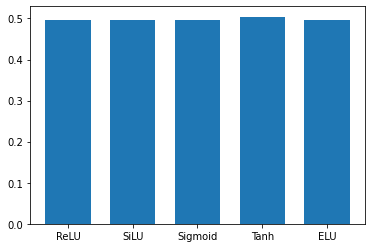

In [ ]:
#ENTER CODE HERE
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
  
class Net(Module):   
    def __init__(self, activation):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here:
        '''
        #ENTER CODE HERE
        self.flatten = nn.Flatten()
        if activation == 'ReLU':
          self.activation_f = nn.ReLU()
        elif activation == 'SiLU':
          self.activation_f = nn.SiLU()
        elif activation == 'Sigmoid':
          self.activation_f = nn.Sigmoid()
        elif activation == 'Tanh':
          self.activation_f = nn.Tanh()
        elif activation == 'ELU':
          self.activation_f = nn.ELU()
        self.cnn = nn.Sequential(
          Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

          Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

          Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.fully = nn.Sequential(
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=50176, out_features=4096, bias=True),
          self.activation_f,

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=4096, bias=True),
          self.activation_f,

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=1000, bias=True),
          self.activation_f,
 
          nn.Linear(in_features=1000, out_features=1, bias=True)
          
        )


    def forward(self, x):
        '''
        Define the forward pass
        '''
        #ENTER CODE HERE
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fully(x)
        return x


activation_function = ['ReLU', 'SiLU', 'Sigmoid','Tanh', 'ELU']
accuracy = []
for function in activation_function:
  model = Net(function)
  optimizer = Adam(model.parameters(), lr=0.07)
  criterion = CrossEntropyLoss()
  if torch.cuda.is_available():
      model = model.cuda()
      criterion = criterion.cuda()

  trained_model = calc_loss(model, n_epochs) #train the model
  accuracy.append(calc_accuracy(trained_model)) # report the accuracy 
plt.bar(activation_function, accuracy, width = 0.7)

2. **Which function performs better? Justify.**

ANSWER-

### **Part II: Custom Activation Functions**

#### **(1) Implement any activation function of your OWN and DO NOT USE any predefined PyTorch Activation Functions [ 3 marks]**



```
class custom_activation_function(nn.Module):
    '''
    Implementation of custom activation function
    '''
    def __init__(self, in_features, alpha = None):
        '''
        Initialization
        '''

    def forward(self, x):
        '''
        Forward pass of the function.
        '''

af = custom_activation_function(<some_parameters>)
x = torch.randn(256) # random tensor
x = af(x)
```

Your Network Architecture should be as follows:

```
Net(
  (cnn_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_2): Sequential(
    (0): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_4): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_5): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn_6): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
  )
  (fully_2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (fully_3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1000, bias=True)
  )
  (fully_4): Sequential(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
  (a1): custom_activation_function()
  (a2): custom_activation_function()
  (a3): custom_activation_function()
)
```

Hint: Here, we are asking you to apply Custom activation functions to the Fully Connected Layers in the forward pass of the Network


In [ ]:
class sinc(nn.Module):
    '''
    Implementation of custom activation function
    '''
    def __init__(self, in_features, alpha = None):
        '''
        Initialization
        '''
        super().__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        x = torch.div(torch.sin(x), x) 
        return x

af = sinc(256)
x = torch.randn(256) # random tensor

x = af(x)
from torch.nn.modules.conv import ConvTranspose2d, Conv2d
  
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        '''
        Write the 6 CNNs and 4 fully connected CNNs here:
        '''
        #ENTER CODE HERE
        self.flatten = nn.Flatten()

        
        self.cnn = nn.Sequential(
          Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

          Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

          Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

          Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.fully = nn.Sequential(
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=50176, out_features=4096, bias=True),
          sinc(4096),

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=4096, bias=True),
          sinc(4096),

          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=4096, out_features=1000, bias=True),
          sinc(1000),
 
          nn.Linear(in_features=1000, out_features=1, bias=True)
          
        )


    def forward(self, x):
        '''
        Define the forward pass
        '''
        #ENTER CODE HERE
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fully(x)
        return x

model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 



Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm

100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch : 1, train loss : 0.7607765793800354


Epoch : 1, val loss : 0.7090802192687988


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


Epoch : 2, train loss : 0.6963352560997009


Epoch : 2, val loss : 0.6861377954483032


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 3, train loss : 0.6949841380119324


Epoch : 3, val loss : 0.6949780583381653


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


Epoch : 4, train loss : 0.6929882168769836


Epoch : 4, val loss : 0.6843286752700806


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 5, train loss : 0.6935542225837708


Epoch : 5, val loss : 0.6818326115608215


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 6, train loss : 0.692979097366333


Epoch : 6, val loss : 0.6945844888687134


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 7, train loss : 0.6919146776199341


Epoch : 7, val loss : 0.6832244396209717


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 8, train loss : 0.6925930380821228


Epoch : 8, val loss : 0.684613823890686


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 9, train loss : 0.6925951838493347


Epoch : 9, val loss : 0.6853687167167664


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 10, train loss : 0.6943426132202148


Epoch : 10, val loss : 0.6902614831924438


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 11, train loss : 0.6933682560920715


Epoch : 11, val loss : 0.6852874755859375


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 12, train loss : 0.692594587802887


Epoch : 12, val loss : 0.6905494928359985


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 13, train loss : 0.6932765245437622


Epoch : 13, val loss : 0.691470742225647


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 14, train loss : 0.6937069296836853


Epoch : 14, val loss : 0.6906729340553284


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 15, train loss : 0.6929531693458557


Epoch : 15, val loss : 0.6893856525421143


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 16, train loss : 0.693192720413208


Epoch : 16, val loss : 0.6884992718696594


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 17, train loss : 0.69212806224823


Epoch : 17, val loss : 0.6890357136726379


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 18, train loss : 0.6932178735733032


Epoch : 18, val loss : 0.6880548000335693


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 19, train loss : 0.6932968497276306


Epoch : 19, val loss : 0.6927001476287842


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 20, train loss : 0.6936229467391968


Epoch : 20, val loss : 0.6914616823196411


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Epoch : 21, train loss : 0.6931262016296387


Epoch : 21, val loss : 0.6890508532524109


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 22, train loss : 0.6931591629981995


Epoch : 22, val loss : 0.6886323094367981


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 23, train loss : 0.693007230758667


Epoch : 23, val loss : 0.6963052749633789


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 24, train loss : 0.6932862997055054


Epoch : 24, val loss : 0.6862903237342834


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 25, train loss : 0.6935104131698608


Epoch : 25, val loss : 0.690662145614624


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 26, train loss : 0.6924965381622314


Epoch : 26, val loss : 0.6895765662193298


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 27, train loss : 0.6939523816108704


Epoch : 27, val loss : 0.6922963261604309


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 28, train loss : 0.6929937601089478


Epoch : 28, val loss : 0.6901358366012573


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 29, train loss : 0.6931602954864502


Epoch : 29, val loss : 0.6941836476325989


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 30, train loss : 0.6937524676322937


Epoch : 30, val loss : 0.6861695051193237


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 31, train loss : 0.6931694149971008


Epoch : 31, val loss : 0.6905563473701477


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 32, train loss : 0.6929589509963989


Epoch : 32, val loss : 0.6921103000640869


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 33, train loss : 0.6929024457931519


Epoch : 33, val loss : 0.6897695660591125


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 34, train loss : 0.6933896541595459


Epoch : 34, val loss : 0.6936690807342529


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 35, train loss : 0.6928601861000061


Epoch : 35, val loss : 0.6911802291870117


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 36, train loss : 0.6930503249168396


Epoch : 36, val loss : 0.6932854056358337


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 37, train loss : 0.6931359767913818


Epoch : 37, val loss : 0.692753791809082


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 38, train loss : 0.6933680772781372


Epoch : 38, val loss : 0.6914044618606567


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 39, train loss : 0.6932716369628906


Epoch : 39, val loss : 0.6956871747970581


100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


Epoch : 40, train loss : 0.692853569984436


Epoch : 40, val loss : 0.6861042976379395


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 41, train loss : 0.6939756870269775


Epoch : 41, val loss : 0.6979591250419617


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


Epoch : 42, train loss : 0.6935717463493347


Epoch : 42, val loss : 0.6926184892654419


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


Epoch : 43, train loss : 0.69368976354599


Epoch : 43, val loss : 0.6907996535301208


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 44, train loss : 0.6934245228767395


Epoch : 44, val loss : 0.6921617984771729


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 45, train loss : 0.693690299987793


Epoch : 45, val loss : 0.6903988122940063


100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch : 46, train loss : 0.6938568353652954


Epoch : 46, val loss : 0.6930502653121948


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 47, train loss : 0.6935336589813232


Epoch : 47, val loss : 0.6937514543533325


100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch : 48, train loss : 0.6929765939712524


Epoch : 48, val loss : 0.6912895441055298


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


Epoch : 49, train loss : 0.6928849220275879


Epoch : 49, val loss : 0.6898872256278992


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


Epoch : 50, train loss : nan


Epoch : 50, val loss : nan
the accuracy is 0.5042016806722689
              precision    recall  f1-score   support

      Adults       0.00      0.00      0.00        59
        Kids       0.50      1.00      0.67        60

    accuracy                           0.50       119
   macro avg       0.25      0.50      0.34       119
weighted avg       0.25      0.50      0.34       119

the balanced accuracy is 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5042016806722689

#### **(2) Implement any COMPLEX activation function of your OWN and DO NOT USE any predefined PyTorch Activation Functions {CMPUT 566 only} [ 5 marks]**

Implement any one of the following activation functions 

1. [Soft exponential](https://arxiv.org/pdf/1602.01321.pdf)
2. [BReLU](https://arxiv.org/pdf/1709.04054.pdf)





### **Part III: ResNet [6 marks]**

#### **(1) Implement the following **pretrained ResNet variants****


1. ResNet18
2. ResNet50
3. ResNet152

You can refer the ResNet documentation in the RESOURCES tab.


In [ ]:
model_resnet_variant = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True) #ENTER CODE HERE

'''
DO NOT ALTER THE FOLLOWING CODE
'''
#freeze all the model parameters
for params in model_resnet_variant.parameters():
  params.requires_grad_ = False
'''
DO NOT ALTER THE ABOVE CODE
'''

nr_filters = 2048 #ENTER CODE HERE
model_resnet_variant.fc = nn.Linear(nr_filters, 1)
model_resnet_variant = model_resnet_variant.to(device)

trained_model = calc_loss(model_resnet_variant, n_epochs)
calc_accuracy(trained_model)

NameError: ignored

#### **(2) Which ResNet performs better? Justify.**

Your answer -  

ResNet18 performs better than ResNet50 and ResNet152 since ResNet18 has the highest accuracy.

### **Part IV: Class Imbalance and Sampling [ 5 marks]**




**Consider the imbalanced data and run the following CNN with and without Weighted Random Sampler**



```
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(100352, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #x = x.view(x.size(0), -1)

        return x
        
```


**NOTE:** 
1. Change the main and test paths to the imbalanced dataset.
2. Sampler can be loaded to data loader as follows:



```
sampler_W = <ENTER CODE for weighted sampler>

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, sampler = sampler_W)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)
```

**Has the accuracy gone up or down? Why? Explain your answer.**


In [ ]:
# sampler_W = np.random.rand(len(train_dataset)) * 100
# sampler_W = sampler_W.round()
# sampler_W = sampler_W.astype(int)
# sampler_W = torch.from_numpy(sampler_W)


# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, sampler = sampler_W)
# valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=2)

from torch.nn.modules.conv import ConvTranspose2d, Conv2d

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(NUM_CHANNELS, IMAGE_SIZE, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(IMAGE_SIZE),
            nn.ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(100352, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #x = x.view(x.size(0), -1)

        return x

model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)
trained_model = calc_loss(model, n_epochs) #train the model
calc_accuracy(trained_model) # report the accuracy 

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=100352, out_features=1, bias=True)
  )
)


  0%|          | 0/22 [00:00<?, ?it/s]


RuntimeError: ignored

### **Part V: Data Augmentation{CMPUT 466 only}[ 5 marks]**
1. **What is Data Augmentation? How does it help in combating the data imbalance issue?**

Answer - 

2. **Rotate** the image clockwise by **30** degrees

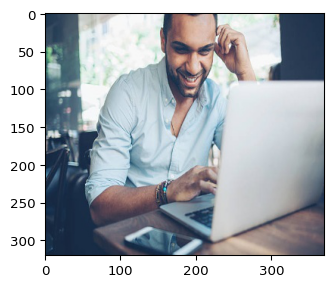

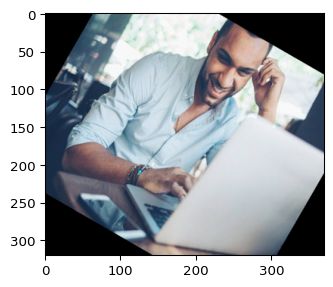

In [ ]:
# importing an image from the imbalanced dataset
image_path = '/content/drive/MyDrive/datasets/imbalanced_data/train/adults/396.jpg' #ENTER THE PATH
'''
DO NOT ALTER THE FOLLOWING CODE
HOWEVER, IF YOU WANT TO ANOTHER LIBRARY, FEEL FREE TO USE IT TOO.
JUST MAKE SURE TO DO THE AUGMENTATION AND THEN SHOW THE AUGMENTED IMAGE
'''

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
%matplotlib inline
image = imageio.imread(image_path)
ia.imshow(image)

# Your code to rotate the image then show it. Use ia.imshow(image) if using imgaug library
aug = iaa.Affine(rotate=30)
image = aug(image=image)
ia.imshow(image)
##

3. Add **Gaussian noise** to the image. 


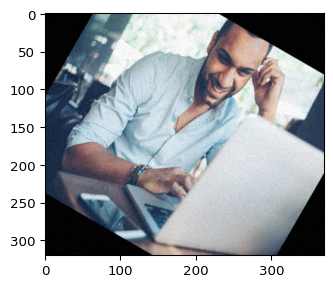

In [ ]:
## YOUR CODE TO ADD GAUSSIAN NOISE TO THE IMAGE
aug = iaa.AdditiveGaussianNoise(scale=5)
image = aug(image=image)
ia.imshow(image)

4. Convolve the image by applying [**Sobel Edge Detection**](https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection) filter. You can apply either X or Y directional kernel and use any library.


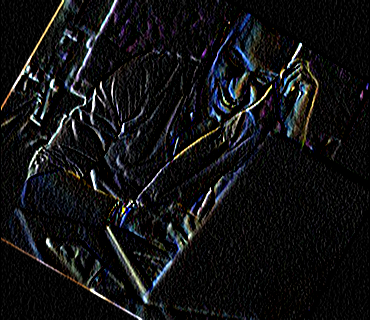

In [ ]:
## YOUR CODE FOR SOBEL EDGE DETECTION
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(image_path)
x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
cv2_imshow(x)

5. Think of **two cases** where augmentations might **not be useful**. For instance, in digits classification, applying a flipping augmentation for the digit 2 might be of no use. 

Answer - 

In [ ]:
1. In face detection, adding hue/saturation augmentation may not be useful
2. In text classification, adding hue/saturation augmentation may not be useful